# Team Members
Berker Uğraş and Berkin Öztürk



# Step 1

At first, we've imported torch, matplotlib, datasets and transforms from the torchvision library. Then we set the device to 'cuda' to use GPU as a hardware accelerator. Finally we downloaded FashionMNIST dataset to '../datasets' folder and seperated them as train and test datasets (train=True and train=false (test))

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


fashionmnist_train=datasets.FashionMNIST("../datasets",train=True,download=True,transform=transforms.ToTensor())
fashionmnist_test=datasets.FashionMNIST("../datasets",train=False,download=True,transform=transforms.ToTensor())

Using cuda device


# Step 2

In this step we have imported DataLoader and TensorDataset from torch.utils.data library.

In [ ]:
#dataloader
from torch.utils.data import DataLoader, TensorDataset

# Step 3

In step 3 we have implemented our DenseNet. There are 4 classes which are defined as subclass nn.Module. These are TransitionLayer, DenseLayer, dense_block and DenseNet. 

**Transition Layer**

TransitionLayer class contains 3 modules and these are BatchNorm2d (to do Batch Normalization according to the input channels), Conv2d (here, we are doing 1x1 convolution to reduce the channel size to 4) and the final one is AveragePooling2D (we are using this function to do average pooling and accordingly reduce the spatial dimension of the feature map). Finally, I would like to mention about dropRate parameter. Dropout is a regularization method that if dropRate is not equal to zero, each channel will be zeroed out independently (with probability dropRate using samples from a Bernoulli Distribution). 





In [ ]:
from os import XATTR_SIZE_MAX

#transitionLayer
class TransitionLayer(nn.Module):
  def __init__(self, in_num, out,dropRate=0.0):
    super(TransitionLayer,self).__init__()
    self.batch=nn.BatchNorm2d(in_num)
    self.conv=nn.Conv2d(in_num,out,kernel_size=1)
    self.avgPool=nn.AvgPool2d(kernel_size=2, stride=2)

    self.dropRate=dropRate
  def forward(self,x):
    x=self.batch(x)
    x=self.conv(x)
    if self.dropRate >0:
      x=F.dropout(x,p=self.dropRate,inplace=False, training=self.training)
    x=self.avgPool(x)

    return x


**Dense Layer**

DenseLayer class contains Batch Normalization, Relu as a activation function and finally Conv2d to do convolution. We set the 'padding' of the convolution function to 1 to preserve the spatial dimensions of feature maps. In the forward function part we've applied those modules (BatchnNorm2 ReLU and conv2d) sequentially. Finally we concatenate the output with input (x). We can consider the these operations as the first layer of the dense block. Since there are 3 layers we are going to repeat these operations for 3 times by using the *Dense Block class*.

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(DenseLayer, self).__init__()
        self.b1 = nn.BatchNorm2d(in_planes)
        self.r1 = nn.ReLU()
        self.c1 = nn.Conv2d(in_planes, out_planes, kernel_size=3,padding=1) #We are using padding 1 to preserve the spatial dimensions
        self.droprate = dropRate

    def forward(self, x):
        out = self.c1(self.r1(self.b1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)


**Dense Block**

'dense_block' class contains the 'make_layer()' function we use to create a Dense Layers as much as user wants. We do this by creating a 'layers' list and adding the layers defined through the 'Dense Layer' class to the 'layers' list by using a 'for loop'. In the end, we return it as an nn.sequential container by putting the 'layers' list inside of it.

In [ ]:
class dense_block(nn.Module):
     def __init__(self, inChannels,num_layers,growthRate,block,dropRate=0.0):
       super(dense_block,self).__init__()
       self.layer = self._make_layer(block, inChannels, growthRate, num_layers, dropRate)
     def _make_layer(self, block, inChannels, growthRate, num_layers, dropRate):
        layers = []
        for i in range(num_layers):
            layers.append(block(inChannels+i*growthRate, growthRate, dropRate))
        return nn.Sequential(*layers)
     def forward(self,x):
        return self.layer(x)


**Dense Net**

'dense_net' class contains dense blocks and transition layers inside of it. In our case, there should have been 2 dense blocks each with 3 layers. So we defined 2 dense blocks and a transition layer using 'dense_block' and 'TransitionLayer' classes, respectively. But before the first dense block, we had to apply 3x3 convolution with 4 output channels and average pooling with stride 2 to reduce the size. After the first dense block, there should be 40 channels since the growth rate is 12 and there are 3 layers (4 (channel size after the first convolution) + 12*3=40). So we used a transition layer between dense blocks to reduce the number of channels to 4 (1x1 conv), and 2x2 average pooling with stride 2 to reduce spatial dimensions. In the end, we applied a Fully Connected Layer (Linear) with 10-dimensional output. In addition to this, in the last part of the init function we initialized parameters (weight bias) as in the code.

In [ ]:
class Dense_net(nn.Module):
    def __init__(self, inChannels,num_layers,growthRate=12,dropRate=0.0):
      super(Dense_net, self).__init__()
      self.c1=nn.Conv2d(inChannels,4,kernel_size=3,padding=1)
      self.avgPool=nn.AvgPool2d(kernel_size=2, stride=2)

      #denseblock number 2
      #number of layers 3
      #First Dense Block
      self.firstDB=dense_block(4,num_layers,growthRate,DenseLayer,dropRate)
      inChannels=int(4+num_layers*growthRate)
      self.firstTra=TransitionLayer(inChannels,4,dropRate=dropRate) #The 1x1 convolution of the transition layer between the blocks reduces the number of channels back to 4

      #Second Dense Block
      self.secondDB=dense_block(4,num_layers,growthRate,DenseLayer,dropRate)
      inChannels=int(4+num_layers*growthRate)
      self.fc=nn.Linear(inChannels,10)
      print(self.fc)
      self.inChannels=inChannels

      for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    
    def forward(self,x):
      x=self.c1(x)
      x=self.avgPool(x)
      # print("after pooling",x.size())
      x=self.firstDB(x)
      # print("after first DB",x.size())
      x=self.firstTra(x)
      # print("after first TRANSITION",x.size())




      x=self.secondDB(x)
      # print("after second DB",x.size())
      x=F.avg_pool2d(x,7)
      # print("after avg",x.size())
      x=x.view(-1,self.inChannels)
      # print("after xview",x.size())
      # print(x)
      x=self.fc(x)
      # print("after fc",x.size())

      return x

# Step 4

In this step, we defined our training procedure and created an instance of our model. We set our hyper parameters (learning rate, batch size , number of epochs, growth rate) manually according to result of loss and accuracy values. We updated the model parameters by using our optimizer (SGD). To monitor the training loss and accuracy rate we benefit from matplotlib and printed the loss value after every epoch. In the end, we coded the validation process to evaluate our test data.

Linear(in_features=40, out_features=10, bias=True)
loss training 0.923771858215332
loss training 0.7839542031288147
loss training 0.5953145623207092
loss training 0.48554912209510803
loss training 0.9495738744735718
loss training 0.724718451499939
loss training 0.8676370978355408
loss training 0.46225816011428833
loss training 0.4506559669971466
loss training 0.43717971444129944
loss training 0.301360160112381
loss training 0.3751559555530548
loss training 0.554939866065979
loss training 0.46413177251815796
loss training 0.34234756231307983
loss training 0.5855364799499512
loss training 0.3920839726924896
loss training 0.43348678946495056
loss training 0.3315598666667938
loss training 0.6988359689712524
loss training 0.4662477970123291
loss training 0.4594237804412842
loss training 0.5769463777542114
loss training 0.5846639275550842
loss training 0.3188495635986328
loss training 0.45596063137054443
loss training 0.4928639829158783
loss training 0.40793508291244507
loss training 0.16454

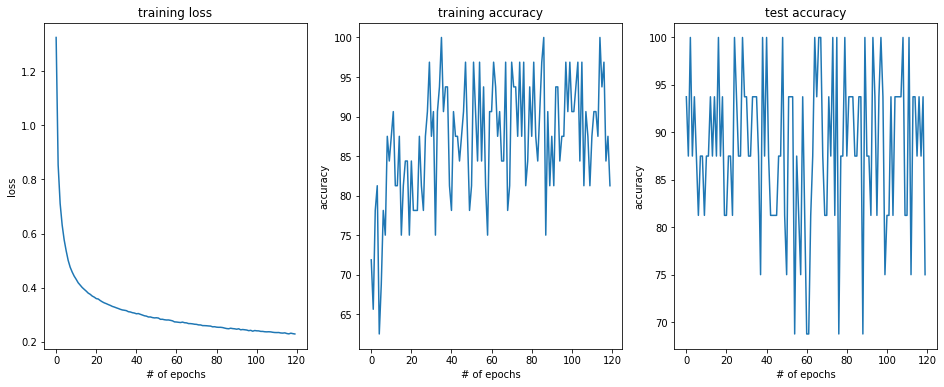

In [ ]:
model=Dense_net(1,3,12,0).to(device)


import torch.optim as optim


#Training
num_epochs=120
bs=64 #generally powers of 2
lr=0.01

#data Loading
dLoader_train = DataLoader(fashionmnist_train,bs, shuffle=True)
dLoader_test = DataLoader(fashionmnist_test,bs, shuffle=True)

#Loss
loss = nn.CrossEntropyLoss()

#optimizer
optimizer=optim.SGD(model.parameters(),lr)

losses=[]
losses_test=[]
accuracy_train=[]    
accuracy_test=[]
temp_Accuracy=0

#accuracy function
avg_accuracy=0
count=0
def accuracy_func(predictions,target,isAvg=0):
    correct=0
    global avg_accuracy
    global count
    global temp_Accuracy
    if(isAvg==1):
        avg_accuracy=avg_accuracy/count
        return avg_accuracy*100
    
    if(count==(len(dLoader_train)*num_epochs)):   
        temp_Accuracy=0
        avg_accuracy=0
        count=0
    for i in range(0,len(target),1):
        if(target[i]==predictions[i]):
            correct=correct+1
    accuracy=correct/len(target)
    temp_Accuracy=accuracy
    avg_accuracy+=accuracy
    count=count+1
  
    
#training data
model.train()
for epoch in range(num_epochs):
    ll=0
    #for training
    for i,(x_batch,y_batch) in enumerate(dLoader_train):
        optimizer.zero_grad()
        y_hat=model(x_batch.to(device))
        _,predicted=torch.max(y_hat.data,1)   
        accuracy_func(predicted,y_batch.to(device))
        lossVal=loss(y_hat,y_batch.to(device))  
        lossVal.backward()
        optimizer.step()
        ll +=lossVal
    print(f'loss training {lossVal}')
    losses.append(ll.item()/len(dLoader_train))
    accuracy_train.append(temp_Accuracy*100)
        
print("Average Accuracy of training data",accuracy_func(0,0,1),"%")
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("training loss")
plt.plot(losses[:])
plt.ylabel('loss')
plt.xlabel('# of epochs')

plt.subplot(1,3,2)
plt.title("training accuracy")
plt.plot(accuracy_train[:])
plt.ylabel('accuracy')
plt.xlabel('# of epochs')


#test data / by using trained model
with torch.no_grad():
    model.eval()
    for epoch in range(num_epochs):
        ll_test=0
        for i,(xbatch,ybatch) in enumerate(dLoader_test):
                yhat=model(xbatch.to(device))
                _,predictions=torch.max(yhat.data,1)
                accuracy_func(predictions,ybatch.to(device))
                lossValtest=loss(yhat,ybatch.to(device))
                ll_test+=lossValtest
        print(f'loss test {lossValtest}')
        losses_test.append(ll_test.item()/len(dLoader_test))
        accuracy_test.append(temp_Accuracy*100)
        
    plt.subplot(1,3,3)  
    plt.title("test accuracy")
    plt.plot(accuracy_test[:])
    plt.ylabel('accuracy')
    plt.xlabel('# of epochs')
        
print("Average Accuracy of test data",accuracy_func(0,0,1),"%") 


# Questions
 • What is the spatial dimension of the first DenseBlock and how many input 
channels and output channels it has?

**Answer**

Spatial dimension of the first denseblock is:

batch size=64

*height*width (spatial dimensions)=14x14

64x14x14

4 input channels, 40 (growth rate is 12 4+12(growth rate)*3(layers)) output channels


---



• What is the spatial dimension of the second DenseBlock?

**Answer**


Because of the transition layer, spatial dimensions of the second block reduced to 7x7.


---

• What dimension is the input into the final FC layer (after the global average pooling)?

**Answer**

After the Global Average Pooling dimensions are:

64 batch size

40 channels

1x1 (heightxwidth)

64x(40x1x1)


then by using view(-1,self.inChannels) I flattened it and finally the  last dimension that I've got before applying fully connected (linear layer) layer is
64x40



# Conclusion and Comments

To get good accuracy and good loss value, we have tried several different combinations and tested them. At first, we set the number of epochs to 36 and batch size to 256. Before long, we have realized that these hyperparameters are not ideal by investigating the loss and accuracy values. Since for the batch normalization batch size is very important and works at optimal between 50-100,  we have set the batch size to 64, increased the epoch size to 120 and set the growth rate to 12. As a result, we got better accuracy and loss results.

For the training data, we got %88.6 average accuracy and for the test data, we got %88.1 average accuracy. Since they are nearly identical (training accuracy a little bit higher), we can consider it as a good outcome and the model is doing what it's supposed to do.

